## Algoritms #4
## Деревья решений

* [Реализация дерева решений для задачи регрессии](#regrtree)

In [315]:
import random
from matplotlib.colors import ListedColormap
from sklearn import model_selection
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from sklearn import model_selection

np.random.seed(42)
random.seed(42)
RANDOM_SEED = 42

%matplotlib inline

В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

## <left>Реализация дерева решений для задачи регрессии<a class="anchor" id="regrtree"></a><left>

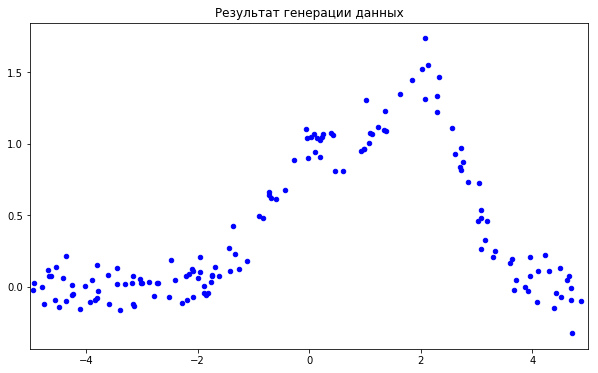

In [316]:
# Генерация датасета с разбивкой

n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y


X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, c="b", s=20)
plt.xlim([-5, 5])
plt.title("Результат генерации данных" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

In [317]:
# Класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

        
# Класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
    
    # Функционал дерева регрессии    

    def predict(self):
        prediction = self.labels.mean()
        return prediction    


# Критерий информативности дерева для регрессии

def variance(labels):       
    return np.var(labels) # возвращает дисперсию 

# Расчет качества

def quality(left_labels, right_labels, current_var):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_var - p * variance(left_labels) - (1 - p) * variance(right_labels)


# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_var = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth, depth=0):
        
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качестве
    if quality == 0 or depth >= max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, depth + 1)
    false_branch = build_tree(false_data, false_labels, depth + 1)   


    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes  

In [318]:
# Построим дерево по обучающей выборке
my_tree = build_tree(X_train, y_train, max_depth=5)

In [319]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -1.1132271031051797
--> True:
  Индекс 0
  Порог -1.6238482859637204
  --> True:
    Индекс 0
    Порог -2.1906549031261924
    --> True:
      Индекс 0
      Порог -4.364416497139763
      --> True:
        Индекс 0
        Порог -4.685708143132658
        --> True:
          Прогноз: 0.0009723878174466404
        --> False:
          Прогноз: 0.04874048040272884
      --> False:
        Индекс 0
        Порог -3.9210857300669555
        --> True:
          Прогноз: -0.06435797907916592
        --> False:
          Индекс 0
          Порог -3.134299411139642
          --> True:
            Индекс 0
            Порог -3.439813595575635
            --> True:
              Прогноз: 0.012402883831623076
            --> False:
              Прогноз: -0.04893970056740354
          --> False:
            Индекс 0
            Порог -2.5070777085112503
            --> True:
              Прогноз: 0.00735301496198109
            --> False:
              Прогноз: 0.021829831287106

In [320]:
# Получим ответы для обучающей выборки 
train_answers = predict(X_train, my_tree)

In [321]:
# И получим ответы для тестовой выборки
answers = predict(X_test, my_tree)

In [322]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Для задачи регрессии подойдет метрика MSE
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [323]:
# Точность на обучающей выборке
train_err = calc_mse(y_train, train_answers)
train_err

0.010032266937024801

In [324]:
# Точность на тестовой выборке
test_err = calc_mse(y_test, answers)
test_err

0.01752315326757557

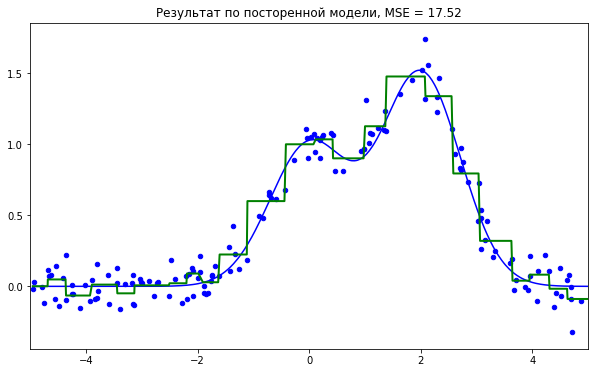

In [325]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, answers, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Результат по посторенной модели, MSE = %.2f" % np.sum((y_test - answers) ** 2))
plt.show()

In [326]:
# Сравним со встроенным методом

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

calc_mse(y_test, reg_tree.predict(X_test))

0.017110028700759207